In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.sequence import pad_sequences
import keras.models as models
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, SimpleRNN, Dense, Bidirectional, LSTM
from keras import losses
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import seaborn as sns

import tensorflow as tf
tf.get_logger().setLevel('ERROR')


Using TensorFlow backend.


In [2]:
path_embeddings = Path('embeddings/glove.6B.100d.txt')
path_train = Path('data/eng.train')
path_val = Path('data/eng.valid')
path_test = Path('data/eng.test')

# Collecting the Embeddings
1. Download the GloVe embeddings 6B from [ https://nlp.stanford.edu/projects/glove/ ](https://nlp.stanford.edu/projects/glove/) and keep the 100d vectors. 
2. You have a local copy of this script in  /usr/local/cs/EDAN95/datasets/;
3. Write a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.
4. Using a cosine similarity, compute the 5 closest words to the words _table_, _france_, and _sweden_.

In [3]:
def load_embeddings(path):
    embedding_index = {}
    with path.open() as f:
        for line in f:
            values = line.split()
            word = values[0]
            coef = np.array(values[1:], dtype='float32')
            embedding_index[word] = coef

    #print(f'found {len(embedding_index)} word vectors')

    return embedding_index

embedding_index = load_embeddings(path_embeddings)

In [4]:

def print_most_similar(embeddings, word, n=5):
    indices = np.argpartition(
        cosine_similarity([embeddings[word]], list(embedding_index.values()))[0],
        -n)[-n:]
    print(word, np.array(list(embeddings.keys()))[indices])

print_most_similar(embedding_index, 'table')
print_most_similar(embedding_index, 'france')
print_most_similar(embedding_index, 'sweden')

table ['room' 'bottom' 'place' 'tables' 'table']
france ['spain' 'france' 'belgium' 'french' 'britain']
sweden ['netherlands' 'sweden' 'finland' 'norway' 'denmark']


# Reading the Corpus and Building Indices

You will read the corpus with programs available from [https://github.com/pnugues/edan95](https://github.com/pnugues/edan95).
These programs will enable you to load the files in the form of a list of dictionaries.

1. Write a function that for each sentence returns the **x** and **y** lists of symbols consisting of words and NER tags. For the second sentence of the training set, you should have:  

```
    x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']  

    y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']  
```

Some datasets you may find on the web use a different NER tagset, where   I- is replaced with   B-, like   B-ORG instead of   I-ORG. This will not change the results.
            
2. Apply this function to your datasets so that you create **X** and **Y** lists of lists consisting of words and NER tags 
3. Create a vocabulary of all the words observed in the training set and the words in GloVe. You should find 402,595 different words.
4. Create indices and inverted indices for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.

## Data format
Each word has been put on a separate line and there is an empty line after each sentence.

Each row has four columns separated by a single space:
1. Word
2. POS
3. Syntactic chunk tag
4. Named Entity tag

Chunks and N.E use IOB tags.

In [5]:
!pip3 install regex --user

In [6]:
from conll_dictorizer import CoNLLDictorizer

def load_data(path):
    column_names = ['form', 'pos', 'chunk', 'ne']
    dictorizer = CoNLLDictorizer(column_names, col_sep=' +')
    
    return dictorizer.transform(path.read_text())

train_sentences = load_data(path_train)

In [7]:
def extract_sentences(sentences):
    x = [[word['form'].lower() for word in sentence] for sentence in sentences]
    y = [[word['ne'] for word in sentence] for sentence in sentences]

    return x,y

x_train, y_train = extract_sentences(train_sentences)

x_train[1],y_train[1]

(['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O'])

In [8]:
vocabulary = set(embedding_index.keys()).union({word['form'].lower() for sentence in train_sentences for word in sentence})
len(vocabulary)

402595

In [9]:
def create_word_index(vocabulary):
    return dict(zip(vocabulary, range(2, 2 + len(vocabulary))))

word_index = create_word_index(vocabulary)
ne_index = create_word_index(set().union(*y_train))

# Building the Embedding Matrix

1. Create a matrix of dimensions (_M_, _N_), where _M_, will the size of the vocabulary: The unique words in the training set and the words in GloVe, and _N_, the dimension of the embeddings.    The padding symbol and the unknown word symbol will be part of the vocabulary.    The shape of your matrix should be: (402597, 100). Initialize it with random values.
            
2. Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section.

In [10]:
def build_embdding_matrix(word_index, embedding_dim=100):
    not_found = 0
    embdding_matrix = np.random.normal(0, 1,(len(word_index) + 2, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embdding_matrix[i] = embedding_vector
        else:
            not_found += 1

#     print(f"{not_found} words missing from glove")
    
    return embdding_matrix

embedding_matrix = build_embdding_matrix(word_index)

embedding_matrix.shape


(402597, 100)

# Creating the **X** and **Y** Sequences

You will now create the input and output sequences with numerical indices

1. Convert the **X** and **Y** lists of symbols in lists of numbers using the indices you created.
            
2. Pad the sentences using the   pad_sequences function. As maximum length and   maxlen argument, you will use 150 or greater. What matters is that you have a length that is larger than the maximum length observed in your training and development corpora. After padding, the second sentence you look like (the indices are not necessarily the same).

```
x = [ 0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0 142143 307143 161836  91321 363368  83766  85852 218260    936]
y = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 9 6 9 9 9 6
 9 9]
```

3. Do the same for the development set.

In [11]:
def texts_to_sequences(texts, index):
    return [[index.get(word, 1) for word in text] for text in texts]

In [12]:
x_train = texts_to_sequences(x_train, word_index)
y_train = texts_to_sequences(y_train, ne_index)

x_train = pad_sequences(x_train, 150)
y_train = pad_sequences(y_train, 150)

x_train[1], y_train[1]

(array([     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0, 

In [13]:
# Load validation data
val_sentences = load_data(path_val)
x_val, y_val = extract_sentences(val_sentences)

x_val = pad_sequences(
    texts_to_sequences(x_val, word_index),
    150)
y_val = pad_sequences(
    texts_to_sequences(y_val, ne_index),
    150)

# Building a Simple Recurrent Neural Network

1. Create a simple recurrent network and train a model with the training set. As layers, you will use   Embedding,   SimpleRNN, and   Dense.
            
2. Compile and fit your network. You will report the training and validation losses and accuracies and comment on the possible overfit.
            
3. Apply your network to the test set and report the accuracy you obtained. You will use the   evaluate method.

In [14]:
y_train = to_categorical(y_train, num_classes=len(ne_index) + 2)
y_val = to_categorical(y_val, num_classes=len(ne_index) + 2)

In [15]:


model = Sequential([
    Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], input_length=150, mask_zero=True),
    SimpleRNN(32, return_sequences=True),
    Dense(len(ne_index) + 2, activation='softmax')
])

model.layers[0].set_weights([embedding_matrix])

In [16]:
model.compile(optimizer='rmsprop', loss=losses.categorical_crossentropy, metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[
                        EarlyStopping(monitor='val_acc', patience=4, verbose=1),
                        ModelCheckpoint('simple-best.h5', save_best_only=True, monitor='val_acc', verbose=1),
                        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, verbose=1)]
                   )

Train on 14987 samples, validate on 3466 samples
Epoch 1/30
14987/14987 [==============================] - 61s 4ms/step - loss: 0.0320 - acc: 0.8996 - val_loss: 0.0199 - val_acc: 0.9417

Epoch 00001: val_acc improved from -inf to 0.94170, saving model to simple-best.h5
Epoch 2/30
14987/14987 [==============================] - 60s 4ms/step - loss: 0.0156 - acc: 0.9481 - val_loss: 0.0164 - val_acc: 0.9510

Epoch 00002: val_acc improved from 0.94170 to 0.95101, saving model to simple-best.h5
Epoch 3/30
14987/14987 [==============================] - 60s 4ms/step - loss: 0.0128 - acc: 0.9563 - val_loss: 0.0149 - val_acc: 0.9563

Epoch 00003: val_acc improved from 0.95101 to 0.95630, saving model to simple-best.h5
Epoch 4/30
14987/14987 [==============================] - 60s 4ms/step - loss: 0.0113 - acc: 0.9615 - val_loss: 0.0139 - val_acc: 0.9588

Epoch 00004: val_acc improved from 0.95630 to 0.95884, saving model to simple-best.h5
Epoch 5/30
14987/14987 [==============================] - 

In [31]:
def plot_training_history(history):
    x = list(range(1, len(history.history['acc']) + 1))
    
    plt.plot(x, history.history['acc'])
    plt.plot(x, history.history['val_acc'])
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

    plt.plot(x, history.history['loss'])
    plt.plot(x, history.history['val_loss'])
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

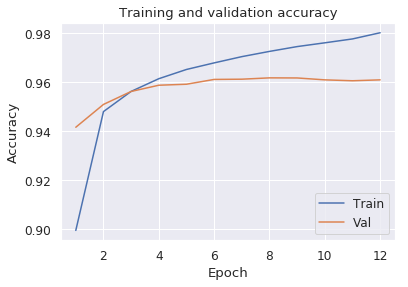

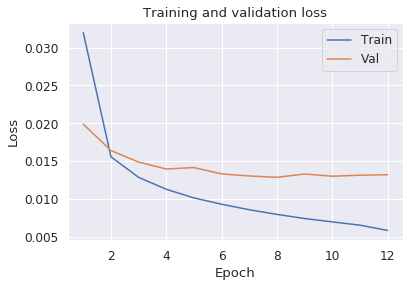

In [32]:
plot_training_history(history)


Evaluating your System

You will use the official script to evaluate the performance of your system

    Use the predict method to predict the tags of the whole test set
    Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space.
    Apply conlleval to your output. Report the F1 result.
    Try to improve your model by modifying some parameters, adding layers, adding Bidirectional and Dropout.
    Evaluate your network again


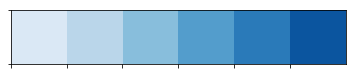

In [21]:
sns.palplot(sns.color_palette("Blues"))
import pandas as pd

def print_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred, list(ne_index.keys()))
    cm_norm = cm / cm.sum(axis=1)
    
    cm_norm_df = pd.DataFrame(cm_norm, index=list(ne_index.keys()), columns=list(ne_index.keys()))
    
    plt.figure(figsize = (10,8))
    sns.set(font_scale=1.1)
    ax = sns.heatmap(
        cm_norm_df,
        annot=True,
        cmap="Blues",
    )

    font_styles = {'fontsize': 16, 'weight': 'bold'}

    ax.set_title('Confusion matrix', {**font_styles, 'fontsize': 25})
    ax.set_xlabel('Predicted', **font_styles)
    ax.set_ylabel('Actual', **font_styles)

    # matplotlib bug fix
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
reverse_ne_index = {v:k for k,v in ne_index.items()}

def test_model(model, path='result.eng'):
    # Load test data
    test_sentences = load_data(path_test)
    x_test, y_test = extract_sentences(test_sentences)
    
    

    x_test = pad_sequences(
        texts_to_sequences(x_test, word_index),
        150)

    y_pred = model.predict_classes(x_test)
    y_pred_unpadded = [preds[-len(trues):] for trues, preds in zip(y_test, y_pred)]
    y_pred_unpadded = [[reverse_ne_index[tag] for tag in sentence] for sentence in y_pred_unpadded]
    
    res = "\n".join(["\n".join([" ".join(["x", "x", true_ne, pred_ne]) for true_ne, pred_ne in zip(true_sent, pred_sent) ])
                     for true_sent, pred_sent in zip(y_test, y_pred_unpadded)])
    
    
    print_metrics([tag for sentence in y_test for tag in sentence], [tag for sentence in y_pred_unpadded for tag in sentence])
    
    Path(path).write_text(res)

    !perl conlleval < $path

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         6
      B-MISC       0.00      0.00      0.00         9
       B-ORG       0.00      0.00      0.00         5
       I-LOC       0.75      0.86      0.80      1919
      I-MISC       0.54      0.63      0.58       909
       I-ORG       0.78      0.65      0.71      2491
       I-PER       0.96      0.88      0.92      2773
           O       0.97      0.98      0.98     38554

    accuracy                           0.94     46666
   macro avg       0.50      0.50      0.50     46666
weighted avg       0.95      0.94      0.94     46666



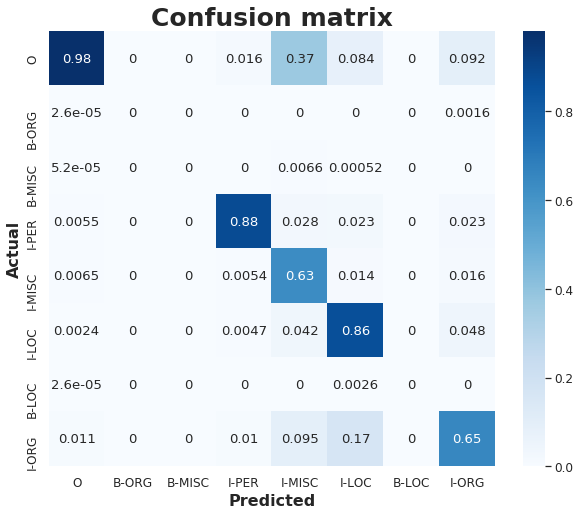

processed 46666 tokens with 5616 phrases; found: 5970 phrases; correct: 4054.
accuracy:  94.45%; precision:  67.91%; recall:  72.19%; FB1:  69.98
              LOC: precision:  70.55%; recall:  82.83%; FB1:  76.20  1956
             MISC: precision:  42.58%; recall:  56.06%; FB1:  48.40  923
              ORG: precision:  63.09%; recall:  60.72%; FB1:  61.88  1585
              PER: precision:  85.06%; recall:  79.96%; FB1:  82.43  1506


In [22]:
test_model(model)

# Building a LSTM Network

1. Create a simple LSTM network and train a model with the train set. As layers, you will use   Embedding,   LSTM, and   Dense.
2. Apply conlleval to your output. Report the F1 result.
3. Try to improve your model by modifying some parameters, adding layers, adding   Bidirectional,  Dropout, possibly mixing  SimpleRNN.
4.  Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.

In [23]:
model2 = Sequential([
    Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], input_length=150, mask_zero=True),
    Bidirectional(
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
    ),
    Dense(len(ne_index) + 2, activation='softmax')
])

model2.layers[0].set_weights([embedding_matrix])

In [24]:
model2.compile(optimizer='rmsprop', loss=losses.categorical_crossentropy, metrics=['acc'])

history2 = model2.fit(x_train,
                    y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    callbacks=[
                        EarlyStopping(monitor='val_acc', patience=4, verbose=1),
                        ModelCheckpoint('best.h5', save_best_only=True, monitor='val_acc', verbose=1),
                        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, verbose=1)]
                   )

Train on 14987 samples, validate on 3466 samples
Epoch 1/30
14987/14987 [==============================] - 159s 11ms/step - loss: 0.0250 - acc: 0.9182 - val_loss: 0.0159 - val_acc: 0.9521

Epoch 00001: val_acc improved from -inf to 0.95209, saving model to best.h5
Epoch 2/30
14987/14987 [==============================] - 159s 11ms/step - loss: 0.0129 - acc: 0.9564 - val_loss: 0.0119 - val_acc: 0.9652

Epoch 00002: val_acc improved from 0.95209 to 0.96516, saving model to best.h5
Epoch 3/30
14987/14987 [==============================] - 158s 11ms/step - loss: 0.0102 - acc: 0.9657 - val_loss: 0.0103 - val_acc: 0.9693

Epoch 00003: val_acc improved from 0.96516 to 0.96929, saving model to best.h5
Epoch 4/30
14987/14987 [==============================] - 159s 11ms/step - loss: 0.0085 - acc: 0.9707 - val_loss: 0.0096 - val_acc: 0.9718

Epoch 00004: val_acc improved from 0.96929 to 0.97181, saving model to best.h5
Epoch 5/30
14987/14987 [==============================] - 158s 11ms/step - los

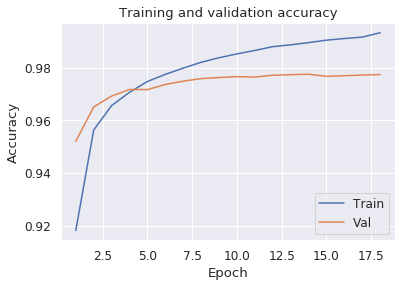

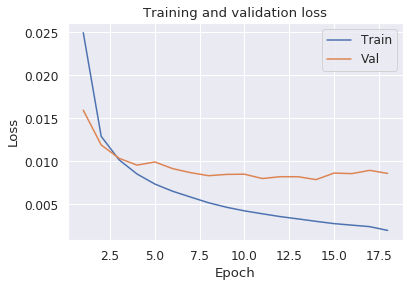

In [33]:
plot_training_history(history2)


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         6
      B-MISC       0.00      0.00      0.00         9
       B-ORG       0.00      0.00      0.00         5
       I-LOC       0.87      0.90      0.89      1919
      I-MISC       0.74      0.73      0.74       909
       I-ORG       0.87      0.81      0.84      2491
       I-PER       0.97      0.92      0.94      2773
           O       0.98      0.99      0.99     38554

    accuracy                           0.97     46666
   macro avg       0.55      0.54      0.55     46666
weighted avg       0.97      0.97      0.97     46666



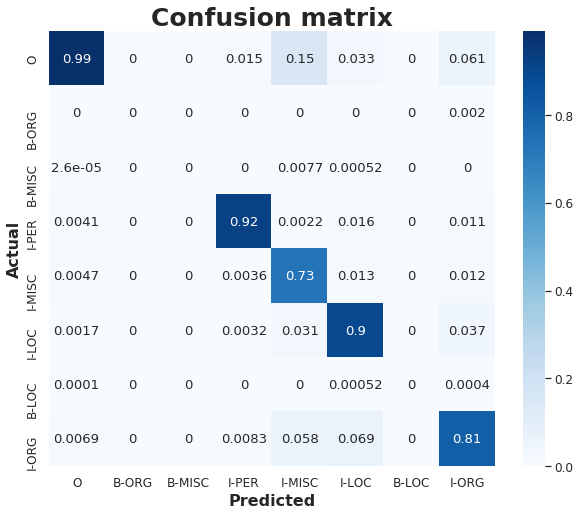

processed 46666 tokens with 5616 phrases; found: 5576 phrases; correct: 4640.
accuracy:  96.69%; precision:  83.21%; recall:  82.62%; FB1:  82.92
              LOC: precision:  85.43%; recall:  88.36%; FB1:  86.87  1723
             MISC: precision:  70.09%; recall:  68.19%; FB1:  69.13  682
              ORG: precision:  79.40%; recall:  78.63%; FB1:  79.01  1631
              PER: precision:  90.58%; recall:  87.08%; FB1:  88.80  1540


In [26]:
test_model(model2)

**Note to self:** *Use min_delta: minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.*